In [1]:
# spark libraries
import pyspark
from pyspark.sql.functions import max

# data wrangling
import pandas as pd
import numpy as np

## Acquire

#### Use spark! 

In [2]:
# create local spark enviroment
spark = pyspark.sql.SparkSession.builder.getOrCreate()

#### Read in 2016 data

In [18]:
df_2016 = spark.read.csv('../data/data_Q*_2016/*.csv', header=True, inferSchema=True)

In [19]:
len(df_2016.columns)

95

#### Read in 2017 data

In [21]:
df_2017 = spark.read.csv('../data/data_Q*_2017/*.csv', header=True, inferSchema=True)

In [22]:
len(df_2017.columns)

95

#### Read in 2018 data

In [23]:
# read quarters in separately since they have different column lengths
df_2018_1 = spark.read.csv('../data/data_Q1_2018/*.csv', header=True, inferSchema=True)
df_2018_2 = spark.read.csv('../data/data_Q2_2018/*.csv', header=True, inferSchema=True)
df_2018_3 = spark.read.csv('../data/data_Q3_2018/*.csv', header=True, inferSchema=True)
df_2018_4 = spark.read.csv('../data/data_Q4_2018/*.csv', header=True, inferSchema=True)

In [24]:
for df in [df_2018_1,df_2018_2,df_2018_3,df_2018_4]:
    print(len(df.columns))

105
109
109
129


#### Read in 2019 data

In [34]:
df_2019 = spark.read.csv('../data/data_Q*_2019/*.csv', header=True, inferSchema=True)

In [35]:
len(df_2019.columns)

129

#### Limit all dataframe to the original 95 columns

In [36]:
cols_2016 = df_2016.columns
cols_2019 = df_2019.columns
remove_traits_list = list(set(cols_2019).difference(cols_2016))

In [37]:
for trait in remove_traits_list:
    df_2018_1 = df_2018_1.drop(trait)
    df_2018_2 = df_2018_2.drop(trait)
    df_2018_3 = df_2018_3.drop(trait)
    df_2018_4 = df_2018_4.drop(trait)
    df_2019 = df_2019.drop(trait)

In [38]:
for df in [df_2016, df_2017, df_2018_1,df_2018_2,df_2018_3,df_2018_4, df_2019]:
    print(len(df.columns))

95
95
95
95
95
95
95


#### Combine all dataframes together

In [39]:
df_raw = df_2016.union(df_2017).union(df_2018_1).union(df_2018_2).union(df_2018_3).union(df_2018_4).union(df_2019)

In [63]:
len(df_raw.columns), df_raw.count()

(95, 121390247)

In [47]:
df_raw.select('serial_number', 'model', 'capacity_bytes',
             'failure', 'smart_9_raw', 'smart_5_raw','smart_187_raw',
             'smart_188_raw', 'smart_197_raw', 'smart_198_raw').printSchema()

root
 |-- serial_number: string (nullable = true)
 |-- model: string (nullable = true)
 |-- capacity_bytes: long (nullable = true)
 |-- failure: integer (nullable = true)
 |-- smart_9_raw: integer (nullable = true)
 |-- smart_5_raw: integer (nullable = true)
 |-- smart_187_raw: integer (nullable = true)
 |-- smart_188_raw: long (nullable = true)
 |-- smart_197_raw: integer (nullable = true)
 |-- smart_198_raw: integer (nullable = true)



#### Extract max values from top five SMART attributes

In [48]:
df = df_raw.groupby('serial_number', 'model', 'capacity_bytes'
                   ).agg(max('failure'), max('smart_9_raw'), max('smart_5_raw'), max('smart_187_raw'),
                        max('smart_188_raw'), max('smart_197_raw'), max('smart_198_raw')
                        )

In [65]:
len(df.columns), df.count()

(9, 169073)

#### Transform to pandas

In [49]:
df = df.select("*").toPandas()

#### Save dfs as csv for easy access

In [50]:
df.to_csv(r'./hard_drives_smart_5.csv')

In [62]:
df = pd.read_csv('hard_drives_smart_5.csv').drop('Unnamed: 0',axis=1)

> Will now code everying in pandas! 

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169073 entries, 0 to 169072
Data columns (total 10 columns):
serial_number         169072 non-null object
model                 169073 non-null object
capacity_bytes        169073 non-null int64
max(failure)          169073 non-null int64
max(smart_9_raw)      161975 non-null float64
max(smart_5_raw)      161851 non-null float64
max(smart_187_raw)    104189 non-null float64
max(smart_188_raw)    104179 non-null float64
max(smart_197_raw)    161841 non-null float64
max(smart_198_raw)    161841 non-null float64
dtypes: float64(6), int64(2), object(2)
memory usage: 12.9+ MB


In [68]:
df.isnull().sum()

serial_number                        1
model                                0
capacity_gigabytes                   0
failure                              0
drive_age_in_years                7098
reallocated_sectors_count         7222
reported_uncorrectable_errors    64884
command_timeout                  64894
current_pending_sector_count      7232
uncorrectable_sector_count        7232
dtype: int64

In [64]:
df.head()

,serial_number,model,capacity_bytes,max(failure),max(smart_9_raw),max(smart_5_raw),max(smart_187_raw),max(smart_188_raw),max(smart_197_raw),max(smart_198_raw)
0,PL1311LAG1SJAA,Hitachi HDS5C4040ALE630,4000787030016,0,43819.0,0.0,NaN,NaN,0.0,0.0
1,Z305KB36,ST4000DM000,4000787030016,0,31045.0,0.0,0.0,0.0,0.0,0.0
2,MJ0351YNG9MZXA,Hitachi HDS5C3030ALA630,3000592982016,0,41668.0,0.0,NaN,NaN,0.0,0.0
3,ZA11NHSN,ST8000DM002,8001563222016,0,26284.0,0.0,0.0,0.0,0.0,0.0
4,MJ1311YNG2ZSEA,Hitachi HDS5C3030ALA630,3000592982016,0,47994.0,0.0,NaN,NaN,0.0,0.0


In [65]:
import pandas as pd
import numpy as np
import re 


def prepare(df):
    
    # Convert capacity column from bytes to gigabytes
    df['capacity_bytes'] = round((df['capacity_bytes']/ 1_000_000_000),1)

    # Convert power hours to years
    df['max(smart_9_raw)'] = round((df['max(smart_9_raw)']/ 8760),1)

    # Drop unnamed column
#     df.drop(columns=('Unnamed: 0'), inplace = True)
    
    # Rename columns appropriately
    df.rename(columns={'capacity_bytes':'capacity_gigabytes','max(failure)':'failure','max(smart_9_raw)':'drive_age_in_years','max(smart_5_raw)':'reallocated_sectors_count','max(smart_187_raw)':'reported_uncorrectable_errors','max(smart_188_raw)':'command_timeout','max(smart_197_raw)':'current_pending_sector_count','max(smart_198_raw)':'uncorrectable_sector_count'}, inplace = True)
    
    return df

In [67]:
prepare(df)

,serial_number,model,capacity_gigabytes,failure,drive_age_in_years,reallocated_sectors_count,reported_uncorrectable_errors,command_timeout,current_pending_sector_count,uncorrectable_sector_count
0,PL1311LAG1SJAA,Hitachi HDS5C4040ALE630,4000.8,0,5.0,0.0,NaN,NaN,0.0,0.0
1,Z305KB36,ST4000DM000,4000.8,0,3.5,0.0,0.0,0.0,0.0,0.0
2,MJ0351YNG9MZXA,Hitachi HDS5C3030ALA630,3000.6,0,4.8,0.0,NaN,NaN,0.0,0.0
3,ZA11NHSN,ST8000DM002,8001.6,0,3.0,0.0,0.0,0.0,0.0,0.0
4,MJ1311YNG2ZSEA,Hitachi HDS5C3030ALA630,3000.6,0,5.5,0.0,NaN,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
169068,ZCH07T8J,ST12000NM0007,-0.0,0,NaN,NaN,NaN,NaN,NaN,NaN
169069,PL1331LAHDXS7H,HGST HMS5C4040BLE640,-0.0,0,NaN,NaN,NaN,NaN,NaN,NaN
169070,ZCH0CCWS,ST12000NM0007,-0.0,0,NaN,NaN,NaN,NaN,NaN,NaN
169071,ZJV2TH56,ST12000NM0007,-0.0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [69]:
def get_manufacturer(model):
    if model.startswith('ST'):
        return 'seagate'
    elif model.startswith('Sea'):
        return 'seagate'
    elif model.startswith('HGST'):
        return 'hitachi'
    elif model.startswith('Hit'):
        return 'hitachi'
    elif model.startswith('TOS'):
        return 'toshiba'
    elif model.startswith('DEL'):
        return 'dell'
    elif model.startswith('WD'):
        return 'western digital'
    elif model.startswith('Sam'):
        return 'samsung'
    elif model.startswith('SAM'):
        return 'samsung'
    else:
        return 'unknown'

In [71]:
df['manufacturer'] = df.model.apply(get_manufacturer)

In [73]:
df.manufacturer.value_counts()

seagate            110097
hitachi             53473
western digital      2826
toshiba              2604
dell                   60
samsung                11
unknown                 2
Name: manufacturer, dtype: int64

In [75]:
df [df.manufacturer == 'unknown']

,serial_number,model,capacity_gigabytes,failure,drive_age_in_years,reallocated_sectors_count,reported_uncorrectable_errors,command_timeout,current_pending_sector_count,uncorrectable_sector_count,manufacturer
33381,0F112CC45,00MD00,4000.8,0,1.7,0.0,0.0,0.0,0.0,0.0,unknown
53781,NaN,00MD00,4000.8,0,1.7,0.0,0.0,1.0,0.0,0.0,unknown


In [77]:
len(df.serial_number.unique())

162031

In [79]:
df.shape

(169073, 11)

In [81]:
df.isnull().sum()

serial_number                        1
model                                0
capacity_gigabytes                   0
failure                              0
drive_age_in_years                7098
reallocated_sectors_count         7222
reported_uncorrectable_errors    64884
command_timeout                  64894
current_pending_sector_count      7232
uncorrectable_sector_count        7232
manufacturer                         0
dtype: int64

In [85]:
df [df.serial_number.duplicated(keep=False)].sort_values('serial_number')

,serial_number,model,capacity_gigabytes,failure,drive_age_in_years,reallocated_sectors_count,reported_uncorrectable_errors,command_timeout,current_pending_sector_count,uncorrectable_sector_count,manufacturer
11635,2AG8AVRY,HGST HUH721212ALN604,12000.1,0,0.1,0.0,NaN,NaN,0.0,0.0,hitachi
77725,2AG8AVRY,HGST HUH721212ALN604,-0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,hitachi
140270,2AGGHJVY,HGST HUH721212ALN604,12000.1,0,0.1,0.0,NaN,NaN,0.0,0.0,hitachi
125080,2AGGHJVY,HGST HUH721212ALN604,-0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,hitachi
97136,2AGGJT1Y,HGST HUH721212ALN604,12000.1,0,0.1,0.0,NaN,NaN,0.0,0.0,hitachi
...,...,...,...,...,...,...,...,...,...,...,...
114807,ZJV2SFDX,ST12000NM0007,12000.1,0,0.6,0.0,0.0,0.0,0.0,0.0,seagate
169071,ZJV2TH56,ST12000NM0007,-0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,seagate
28403,ZJV2TH56,ST12000NM0007,12000.1,0,0.6,0.0,0.0,0.0,0.0,0.0,seagate
146131,ZJV4PYR5,ST12000NM0007,12000.1,0,0.2,0.0,0.0,0.0,0.0,0.0,seagate


In [99]:
df [(df.capacity_gigabytes < 1) & (df.failure == 1)]

,serial_number,model,capacity_gigabytes,failure,drive_age_in_years,reallocated_sectors_count,reported_uncorrectable_errors,command_timeout,current_pending_sector_count,uncorrectable_sector_count,manufacturer
17402,45D7K133FMYB,TOSHIBA MD04ABA400V,-0.0,1,NaN,NaN,NaN,NaN,NaN,NaN,toshiba
66669,ZCH071VT,ST12000NM0007,-0.0,1,NaN,NaN,NaN,NaN,NaN,NaN,seagate
149628,ZA18AAR1,ST8000NM0055,-0.0,1,NaN,NaN,NaN,NaN,NaN,NaN,seagate


In [102]:
df [df.serial_number == '45D7K133FMYB']

,serial_number,model,capacity_gigabytes,failure,drive_age_in_years,reallocated_sectors_count,reported_uncorrectable_errors,command_timeout,current_pending_sector_count,uncorrectable_sector_count,manufacturer
17402,45D7K133FMYB,TOSHIBA MD04ABA400V,-0.0,1,NaN,NaN,NaN,NaN,NaN,NaN,toshiba
145604,45D7K133FMYB,TOSHIBA MD04ABA400V,4000.8,0,3.4,0.0,NaN,NaN,0.0,0.0,toshiba


In [90]:
import seaborn as sns 
import matplotlib.pyplot as plt

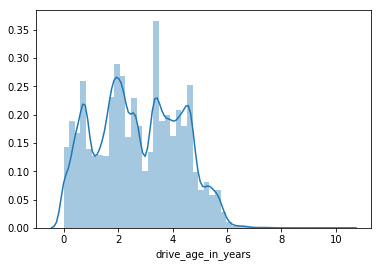

In [93]:
sns.distplot(df.drive_age_in_years.dropna())

In [97]:
df.failure.value_counts()

0    163141
1      5932
Name: failure, dtype: int64

In [103]:
df.model.value_counts()

ST12000NM0007           39779
ST4000DM000             36802
ST8000NM0055            17305
HGST HMS5C4040BLE640    17011
HGST HUH721212ALN604    12036
                        ...  
WDC WD1001FALS              1
WDC WD800LB                 1
WDC WD2500AAJB              1
WDC WD15EARS                1
WDC WD10EALS                1
Name: model, Length: 103, dtype: int64

In [118]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169073 entries, 0 to 169072
Data columns (total 11 columns):
serial_number                    169072 non-null object
model                            169073 non-null object
capacity_gigabytes               169073 non-null float64
failure                          169073 non-null int64
drive_age_in_years               161975 non-null float64
reallocated_sectors_count        161851 non-null float64
reported_uncorrectable_errors    104189 non-null float64
command_timeout                  104179 non-null float64
current_pending_sector_count     161841 non-null float64
uncorrectable_sector_count       161841 non-null float64
manufacturer                     169073 non-null object
dtypes: float64(7), int64(1), object(3)
memory usage: 14.2+ MB


In [126]:
df.capacity_gigabytes.value_counts()

 4000.8     64886
 12000.1    50729
 8001.6     26108
-0.0         7031
 3000.6      6789
 2000.4      4678
 500.1       2547
 6001.2      2411
 14000.5     1302
 10000.8     1255
 1000.2       388
 1500.3       267
 250.1        211
 160.0        209
 320.1        116
 480.0         60
 5001.0        46
 80.0          32
 137.4          7
 250.0          1
Name: capacity_gigabytes, dtype: int64

In [129]:
for col in df.columns:
    print(col)
    print(df[col].value_counts())
    print()

serial_number
PL2331LAHB93UJ     3
ZA21DT0A           2
ZA181EC0           2
ZA189K99           2
AAHKXMPH           2
                  ..
Z305PHQH           1
PL2331LAGMTX9J     1
WD-WXL1H643788L    1
MJ1321YNG0XUPA     1
ZA12X1WF           1
Name: serial_number, Length: 162030, dtype: int64

model
ST12000NM0007           39779
ST4000DM000             36802
ST8000NM0055            17305
HGST HMS5C4040BLE640    17011
HGST HUH721212ALN604    12036
                        ...  
WDC WD1001FALS              1
WDC WD800LB                 1
WDC WD2500AAJB              1
WDC WD15EARS                1
WDC WD10EALS                1
Name: model, Length: 103, dtype: int64

capacity_gigabytes
 4000.8     64886
 12000.1    50729
 8001.6     26108
-0.0         7031
 3000.6      6789
 2000.4      4678
 500.1       2547
 6001.2      2411
 14000.5     1302
 10000.8     1255
 1000.2       388
 1500.3       267
 250.1        211
 160.0        209
 320.1        116
 480.0         60
 5001.0        46
 80

In [130]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169073 entries, 0 to 169072
Data columns (total 11 columns):
serial_number                    169072 non-null object
model                            169073 non-null object
capacity_gigabytes               169073 non-null float64
failure                          169073 non-null int64
drive_age_in_years               161975 non-null float64
reallocated_sectors_count        161851 non-null float64
reported_uncorrectable_errors    104189 non-null float64
command_timeout                  104179 non-null float64
current_pending_sector_count     161841 non-null float64
uncorrectable_sector_count       161841 non-null float64
manufacturer                     169073 non-null object
dtypes: float64(7), int64(1), object(3)
memory usage: 14.2+ MB


In [131]:
df.describe()

,capacity_gigabytes,failure,drive_age_in_years,reallocated_sectors_count,reported_uncorrectable_errors,command_timeout,current_pending_sector_count,uncorrectable_sector_count
count,169073.000000,169073.000000,161975.000000,161851.000000,104189.000000,1.041790e+05,161841.000000,161841.000000
mean,6829.479693,0.035085,2.720529,69.851802,5.996190,3.264823e+08,6.265940,5.913261
std,3981.085266,0.183996,1.525822,1393.236993,541.364663,3.014661e+10,452.148242,447.550251
min,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,4000.800000,0.000000,1.600000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
50%,4000.800000,0.000000,2.600000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
75%,12000.100000,0.000000,4.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
max,14000.500000,1.000000,10.300000,65392.000000,65535.000000,8.933668e+12,142616.000000,142616.000000


In [151]:
df_fails = df [df.failure == 1]
df_lives = df [df.failure == 0]

In [136]:
df_fails.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5932 entries, 68 to 168960
Data columns (total 11 columns):
serial_number                    5932 non-null object
model                            5932 non-null object
capacity_gigabytes               5932 non-null float64
failure                          5932 non-null int64
drive_age_in_years               5925 non-null float64
reallocated_sectors_count        5924 non-null float64
reported_uncorrectable_errors    4985 non-null float64
command_timeout                  4975 non-null float64
current_pending_sector_count     5914 non-null float64
uncorrectable_sector_count       5914 non-null float64
manufacturer                     5932 non-null object
dtypes: float64(7), int64(1), object(3)
memory usage: 556.1+ KB


In [152]:
df_fails.drive_age_in_years.value_counts(bins=10, sort=False)

(-0.011300000000000001, 1.03]    1461
(1.03, 2.06]                     1843
(2.06, 3.09]                     1164
(3.09, 4.12]                     1095
(4.12, 5.15]                      280
(5.15, 6.18]                       65
(6.18, 7.21]                       11
(7.21, 8.24]                        1
(8.24, 9.27]                        1
(9.27, 10.3]                        4
Name: drive_age_in_years, dtype: int64

In [153]:
df_lives.drive_age_in_years.value_counts(bins=10, sort=False)

(-0.0092, 0.82]    24123
(0.82, 1.64]       15932
(1.64, 2.46]       30531
(2.46, 3.28]       20581
(3.28, 4.1]        29677
(4.1, 4.92]        24448
(4.92, 5.74]        9050
(5.74, 6.56]        1506
(6.56, 7.38]         161
(7.38, 8.2]           41
Name: drive_age_in_years, dtype: int64

In [160]:
df_fails.drive_age_in_years.agg(['mean','median'])

mean      2.060793
median    1.800000
Name: drive_age_in_years, dtype: float64

In [161]:
df_lives.drive_age_in_years.agg(['mean','median'])

mean      2.745578
median    2.700000
Name: drive_age_in_years, dtype: float64

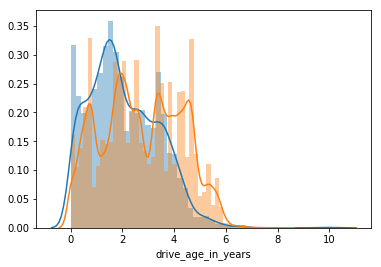

In [165]:
sns.distplot(df_fails.drive_age_in_years.dropna())
sns.distplot(df_lives.drive_age_in_years.dropna())
plt.show()

In [168]:
df_fails.manufacturer.value_counts()

seagate            5078
hitachi             504
western digital     189
toshiba             151
samsung              10
Name: manufacturer, dtype: int64

In [169]:
df_lives.manufacturer.value_counts()

seagate            105019
hitachi             52969
western digital      2637
toshiba              2453
dell                   60
unknown                 2
samsung                 1
Name: manufacturer, dtype: int64

In [170]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169073 entries, 0 to 169072
Data columns (total 11 columns):
serial_number                    169072 non-null object
model                            169073 non-null object
capacity_gigabytes               169073 non-null float64
failure                          169073 non-null int64
drive_age_in_years               161975 non-null float64
reallocated_sectors_count        161851 non-null float64
reported_uncorrectable_errors    104189 non-null float64
command_timeout                  104179 non-null float64
current_pending_sector_count     161841 non-null float64
uncorrectable_sector_count       161841 non-null float64
manufacturer                     169073 non-null object
dtypes: float64(7), int64(1), object(3)
memory usage: 14.2+ MB


In [175]:
df_fails.reallocated_sectors_count.dropna().mean()

1437.187373396354

In [176]:
df_lives.reallocated_sectors_count.dropna().mean()

17.903801137711877